In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from matplotlib.colors import LogNorm
from scipy.integrate import odeint
sns.set_context("talk", font_scale=1.4)


# for using LaTeX fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

## Infer Markov Chain transition matrix from political regime time-series data

In [20]:
# load the Polity5 data from the excel data frame
timeSeries = pd.read_excel('./../data/polity5/p5v2018.xls')

In [21]:
nCountries = len(timeSeries['country'].unique()) # numer of countries

In [22]:
# do some cleaning
timeSeries = timeSeries.dropna(subset=['year', 'country', 'polity2'])

In [23]:
# functions to calculating the transition probabilities

def estimateTransitionMatrix(data,approach='frequentist'):
    
    # construct some output matrices
    countMatrix=np.zeros((21,21)) # empty transition matrix
    
    # split the timeseries into one for each country 
    uniqueCountries = data['country'].unique()
    countryTimeseries =[]
    
    # count for each country the transitions
    for country in uniqueCountries:
        sortedPolity2Country = data[data['country'] == country].sort_values(by='year')["polity2"].tolist()
        T=len(sortedPolity2Country)# number of data points
        for t in range(T-1): # go over all years
            fromTransition = int(sortedPolity2Country[t] + 10)
            toTransition = int(sortedPolity2Country[t+1] + 10)
            
            if  (fromTransition>=0) and ((toTransition>=0)):
                
                # increase the count for this year
                countMatrix[fromTransition,toTransition] = countMatrix[fromTransition,toTransition] + 1
    
    if approach=='frequentist':
        # compute the transition probabilities as count over total outgoing
        P = countMatrix/countMatrix.sum(axis=1)[:,None]
    if approach=='bayesian':
        # we use a Dirichlet prior for each row
        priorMatrix = np.zeros((21,21)) + 1/21
        combinedMatrix = countMatrix + priorMatrix
        # this is the posterior mean
        P = combinedMatrix/combinedMatrix.sum(axis=1)[:,None]
    
    return(P)

def computeSteadyStateBruteForce(transitionMatrix,nSteps,initialCondition=0):
    # computes it the brutal way with iterating the transition
    
    n=transitionMatrix.shape[0] # number of Markov states
    
    if initialCondition==0:
        # if it is zero use a random vector
        x = np.random.rand(n)
        x = x / np.sum(x)
    else:
        # set it to the intial condition that we provided
        x= initialCondition
    # fo over each step
    for i in np.arange(nSteps):
        #x= P_allCountries.dot(x)
        x= x.dot(transitionMatrix)
    
    return(x)

def computeSteadyStateEV(transitionMatrix):
    # compute it as eigenvector
    valsT, vecsT = np.linalg.eig(transitionMatrix.transpose())
    
    # find the index of the eigenvalue closest to 1
    index_ev1 = (np.abs(valsT - 1)).argmin()
    
    v = vecsT[:,index_ev1]
    return((v/np.sum(v)).real) # normalise it for the return and also ignore the imaginary part (from numerical approx.)


def simulateMarkovChain(transitionMatrix,initialCondition,nSteps=100):
    
    n=transitionMatrix.shape[0] # number of states
    
    stateVector=[initialCondition]
    for i in np.arange(nSteps):
        newstate = np.random.choice(np.arange(n), p=transitionMatrix[stateVector[i],:])
        stateVector.append(newstate)
    return(stateVector)
    

def computeHittingTime(transitionMatrix,initialCondition,hittingTarget,rel):
    
    n=transitionMatrix.shape[0] # number of states
    
    hittingTimes = np.zeros(rel)
    
    # go over realisations
    for r in np.arange(rel):
        t=0
        oldstate = initialCondition # we start at the initial condition
        while ((oldstate in hittingTarget) == False):
            t=t+1
            newstate = np.random.choice(np.arange(n), p=transitionMatrix[oldstate,:])
            oldstate = newstate
        # save the number of steps needed
        hittingTimes[r] = t
    return(hittingTimes)  


def createSimpleMarkovChain():
    
    P=np.zeros((2,2)) # empty transition matrix
    
    P[0,0] = 0.9
    P[0,1] = 0.1
    P[1,0] = 0.5
    P[1,1] = 0.5
    
    return(P)

In [47]:

timeSeriesTime1800= timeSeries[timeSeries['year']>=1800]
P_allCountries_Time1800 = estimateTransitionMatrix(timeSeriesTime1800,approach='bayesian')
steadyStateEV_Time1800 = computeSteadyStateEV(P_allCountries_Time1800)

timeSeriesTime1850= timeSeries[timeSeries['year']>=1850]
P_allCountries_Time1850 = estimateTransitionMatrix(timeSeriesTime1850,approach='bayesian')
steadyStateEV_Time1850 = computeSteadyStateEV(P_allCountries_Time1850)

timeSeriesTime1900= timeSeries[timeSeries['year']>=1900]
P_allCountries_Time1900 = estimateTransitionMatrix(timeSeriesTime1900,approach='bayesian')
steadyStateEV_Time1900 = computeSteadyStateEV(P_allCountries_Time1900)

timeSeriesTime1950= timeSeries[timeSeries['year']>=1950]
P_allCountries_Time1950 = estimateTransitionMatrix(timeSeriesTime1950,approach='bayesian')
steadyStateEV_Time1950 = computeSteadyStateEV(P_allCountries_Time1950)


### Plot end of history

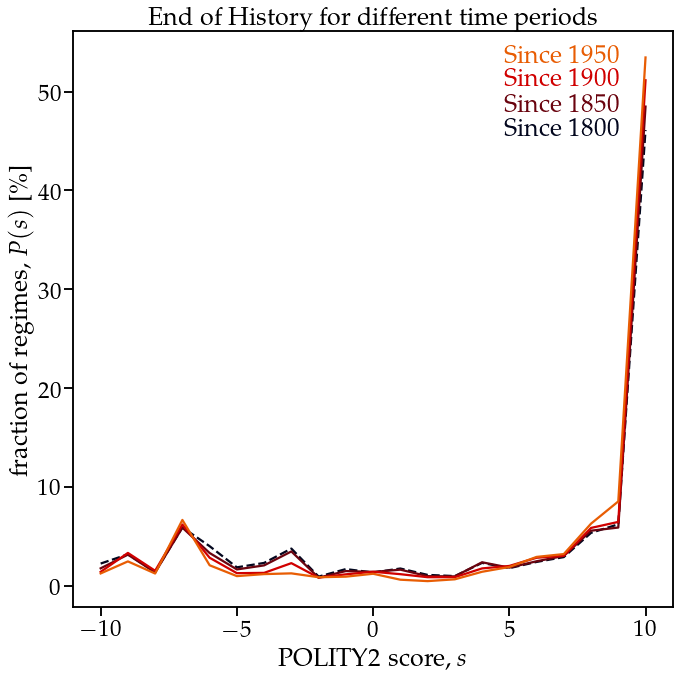

In [45]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(-10,11,1),100*steadyStateEV_Time1800,label='Since 1800', linestyle='dashed',color='#03071e')
plt.plot(np.arange(-10,11,1),100*steadyStateEV_Time1850,label='Since 1850', linestyle='solid',color='#6a040f')
plt.plot(np.arange(-10,11,1),100*steadyStateEV_Time1900,label='Since 1900', linestyle='solid',color='#d00000')
plt.plot(np.arange(-10,11,1),100*steadyStateEV_Time1950,label='Since 1950', linestyle='solid',color='#e85d04')

#plt.legend(loc=0)


plt.text(9,100*steadyStateEV_Time1800[-1],'Since 1800',ha='right',va='center',color='#03071e')
plt.text(9,100*steadyStateEV_Time1850[-1],'Since 1850',ha='right',va='center',color='#6a040f')
plt.text(9,100*steadyStateEV_Time1900[-1],'Since 1900',ha='right',va='center',color='#d00000')
plt.text(9,100*steadyStateEV_Time1950[-1],'Since 1950',ha='right',va='center',color='#e85d04')


plt.title('End of History for different time periods')
plt.xlabel(r'POLITY2 score, $s$')
plt.ylabel(r'fraction of regimes, $P(s)$ [$\%$]')
plt.tight_layout()
plt.savefig('./fig/FigSI-EoH_time.pdf',bbox_inches='tight')

In [60]:
steadyStateEV_Time1950[-1]

0.5344757021491315

### Plot transition matrix

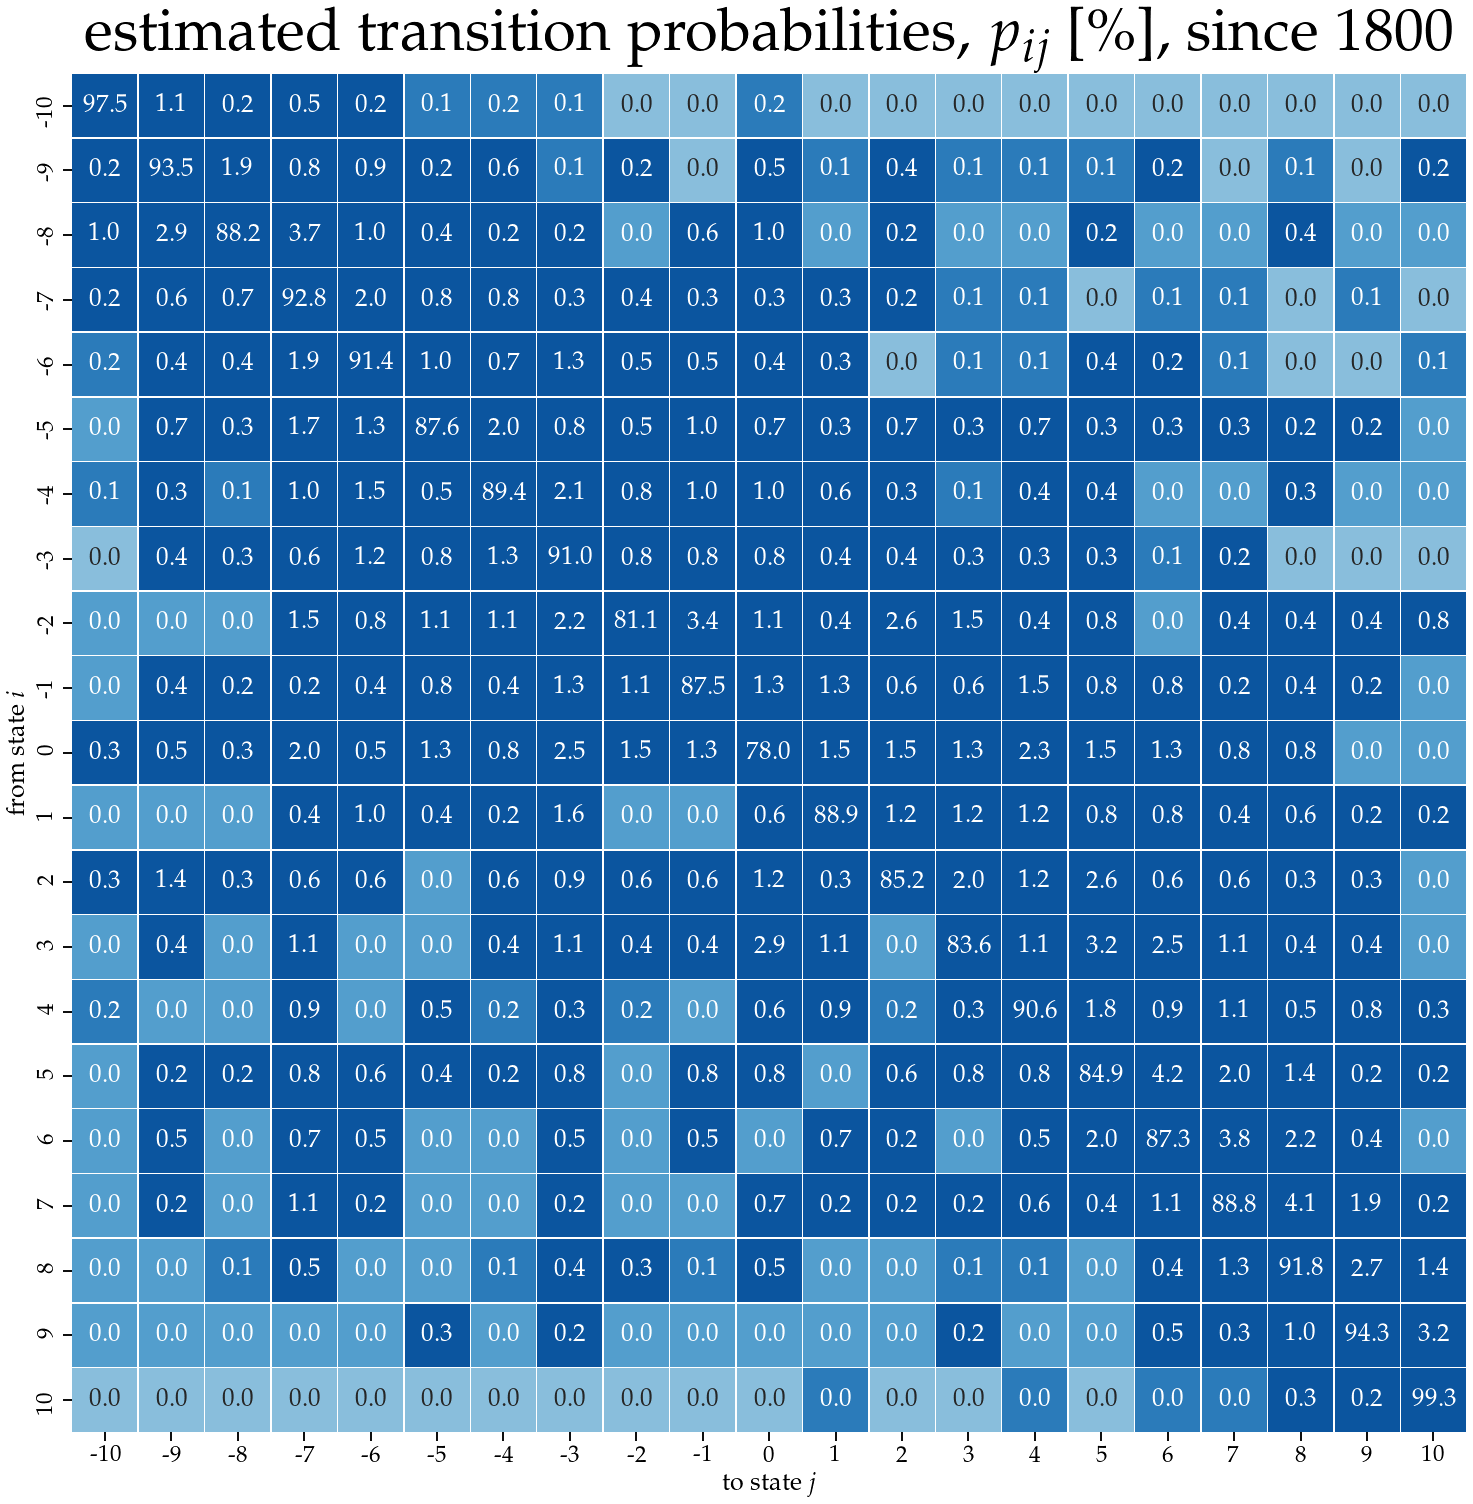

In [53]:
x_axis_labels = np.arange(-10,11,1)
y_axis_labels = np.arange(-10,11,1)
plt.figure(figsize=(25,25))
sns.heatmap(P_allCountries_Time1800*100, annot=True,fmt=".1f",cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels,norm=LogNorm(vmin=P_allCountries_Time1800.min(), vmax=P_allCountries_Time1800.max()), linewidths=.5,cmap=sns.color_palette("Blues"))
plt.ylabel(r'from state $i$')
plt.xlabel(r'to state $j$')
plt.title(r'estimated transition probabilities, $p_{ij}$ [$\%$], since 1800',size=60)
plt.savefig('./fig/estimatedTransitionProbabilities1800.pdf',bbox_inches='tight')

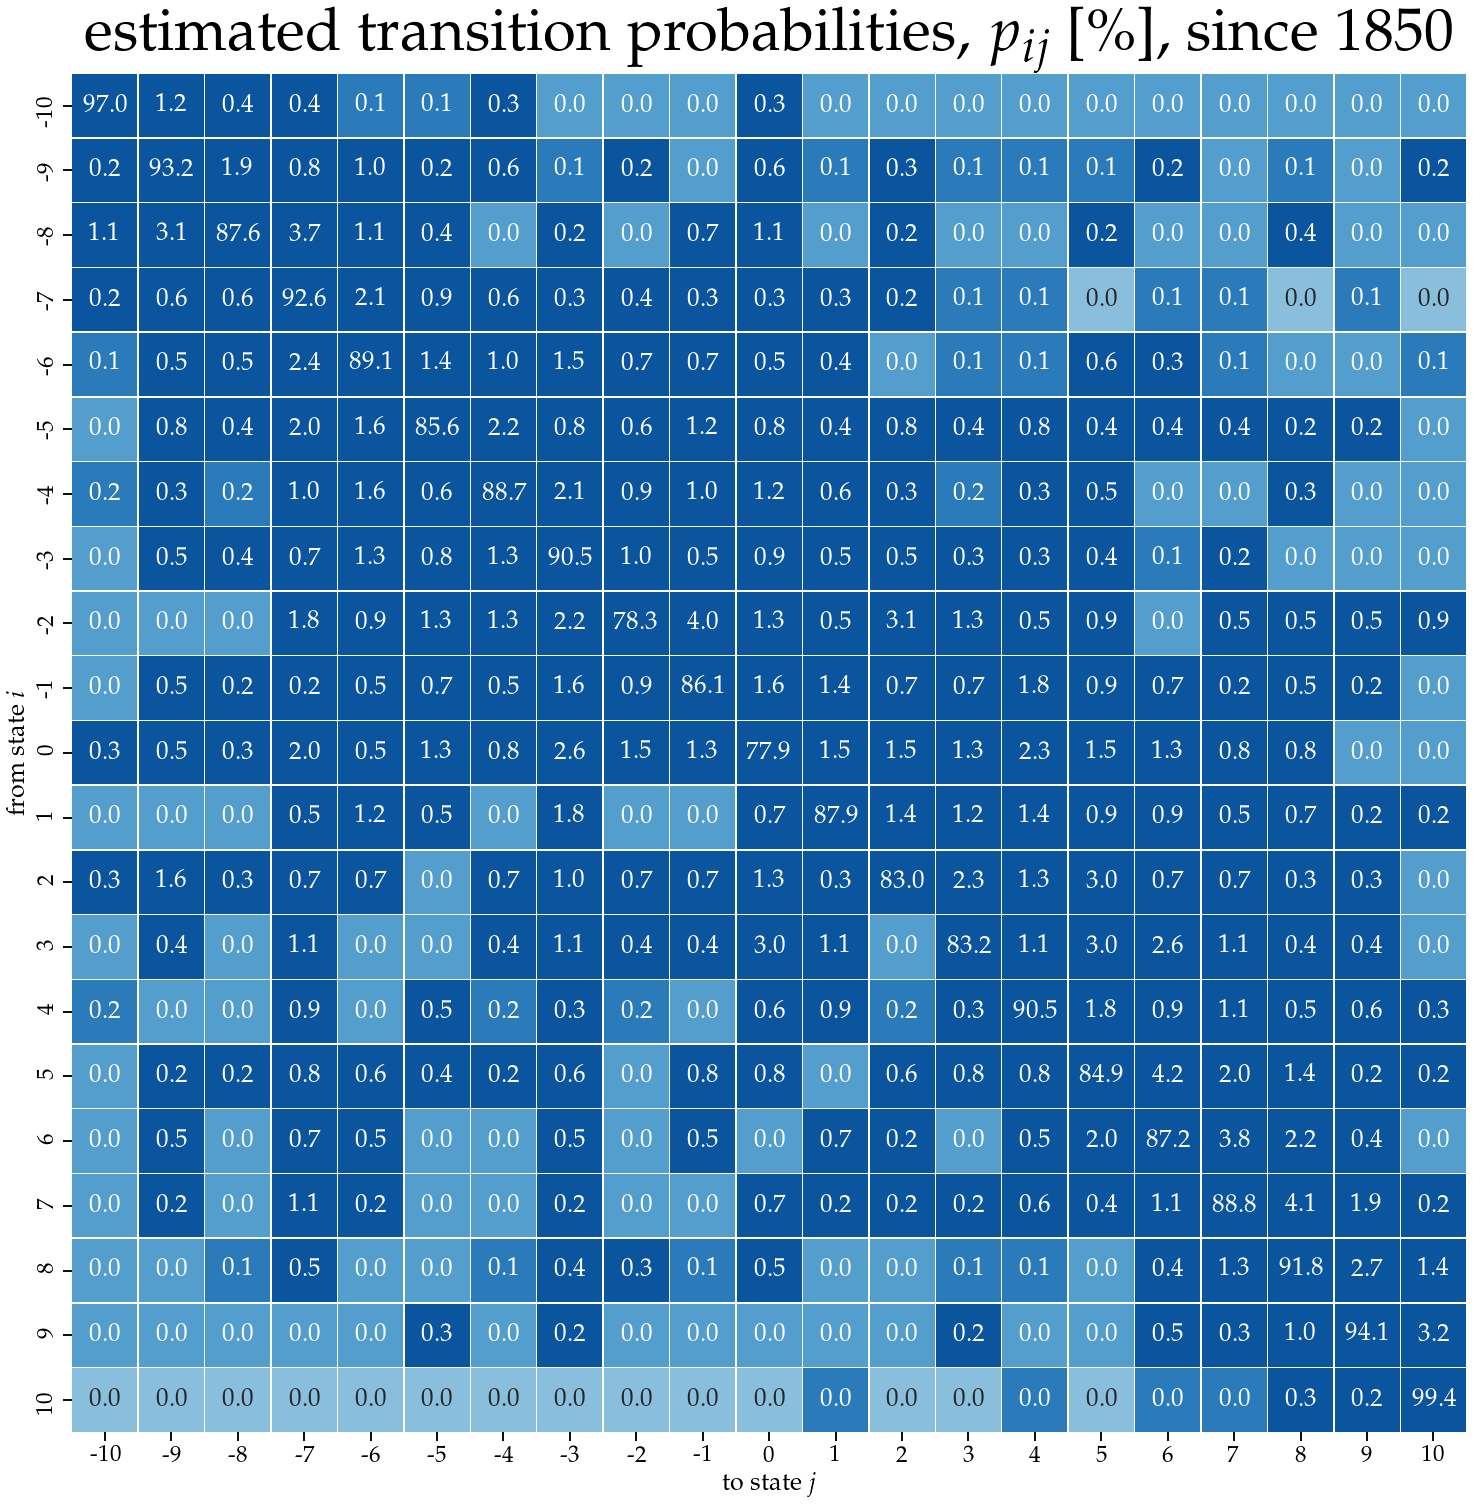

In [54]:
x_axis_labels = np.arange(-10,11,1)
y_axis_labels = np.arange(-10,11,1)
plt.figure(figsize=(25,25))
sns.heatmap(P_allCountries_Time1850*100, annot=True,fmt=".1f",cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels,norm=LogNorm(vmin=P_allCountries_Time1800.min(), vmax=P_allCountries_Time1800.max()), linewidths=.5,cmap=sns.color_palette("Blues"))
plt.ylabel(r'from state $i$')
plt.xlabel(r'to state $j$')
plt.title(r'estimated transition probabilities, $p_{ij}$ [$\%$], since 1850',size=60)
plt.savefig('./fig/estimatedTransitionProbabilities1850.pdf',bbox_inches='tight')

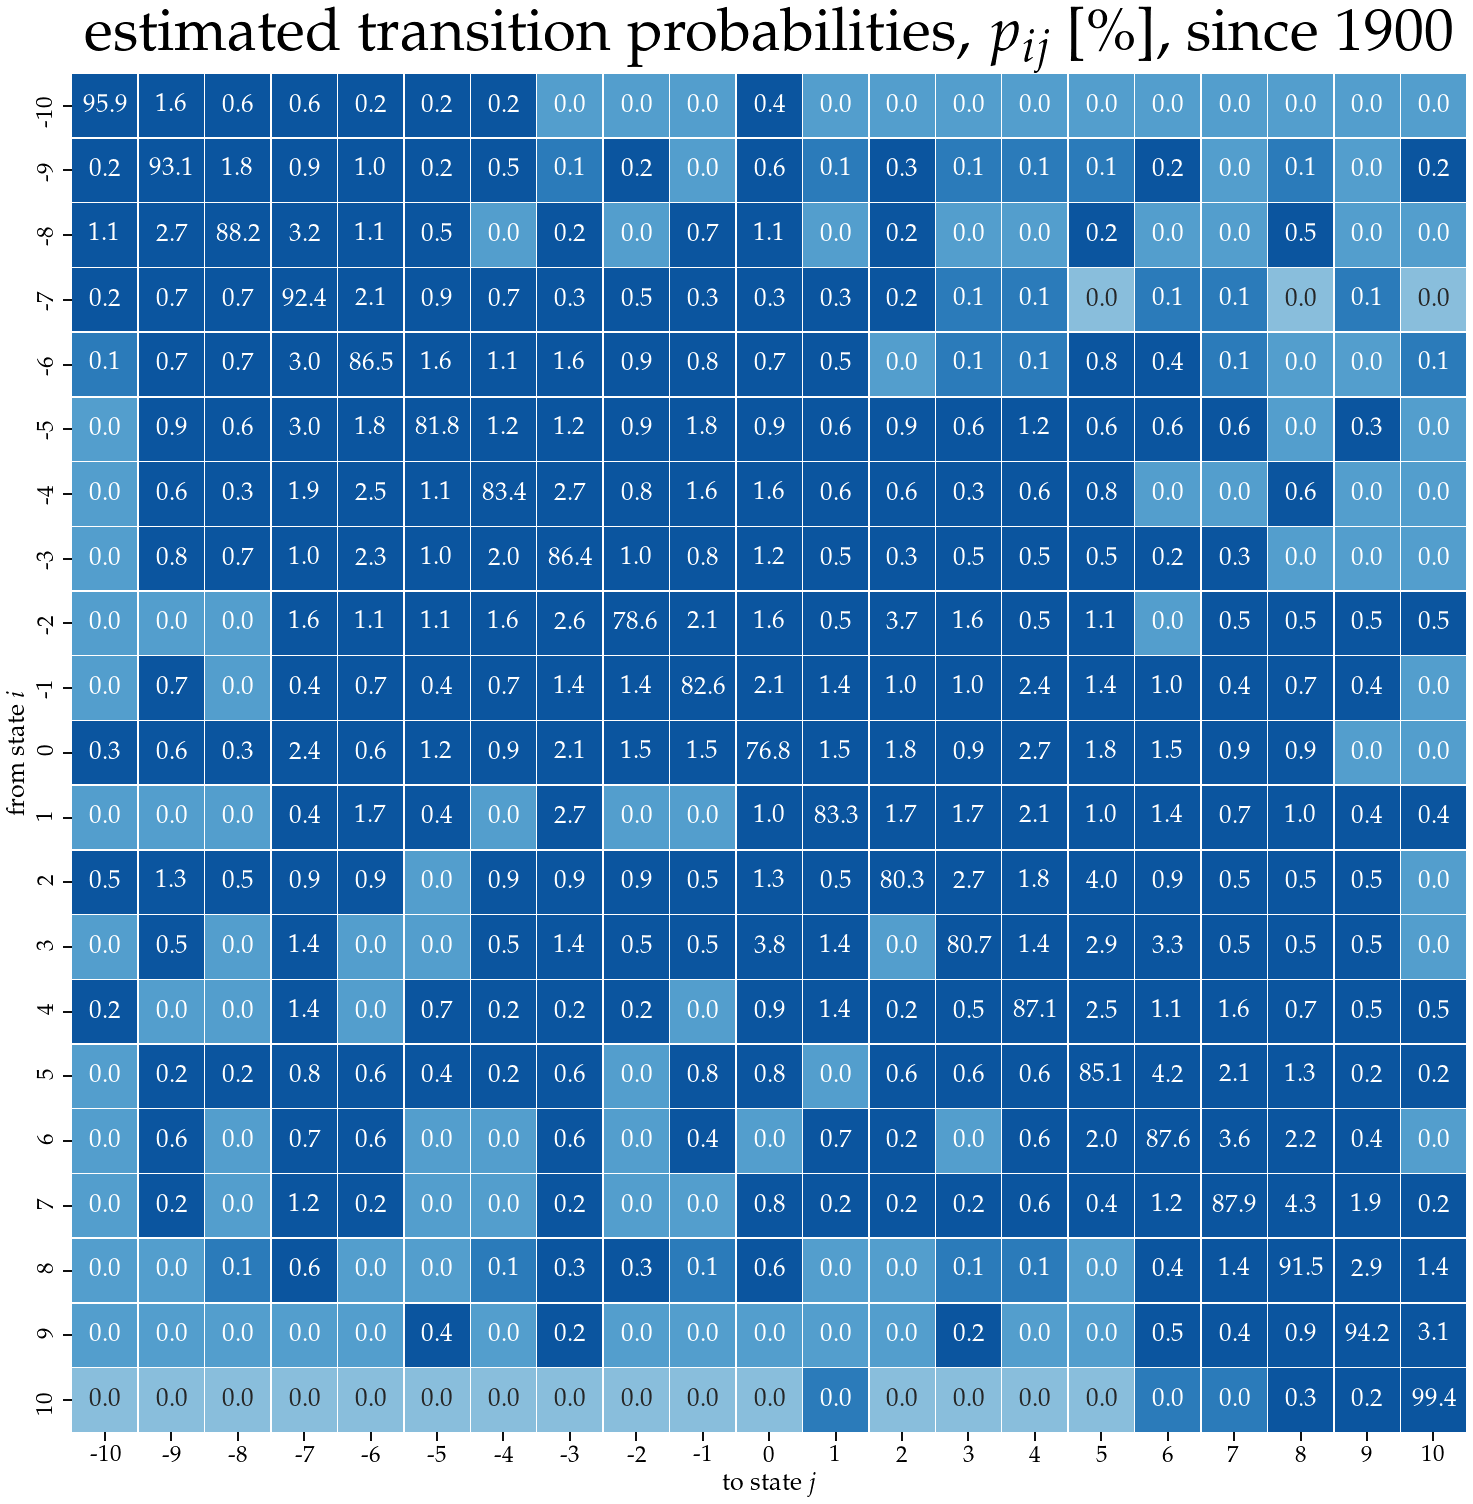

In [55]:
x_axis_labels = np.arange(-10,11,1)
y_axis_labels = np.arange(-10,11,1)
plt.figure(figsize=(25,25))
sns.heatmap(P_allCountries_Time1900*100, annot=True,fmt=".1f",cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels,norm=LogNorm(vmin=P_allCountries_Time1800.min(), vmax=P_allCountries_Time1800.max()), linewidths=.5,cmap=sns.color_palette("Blues"))
plt.ylabel(r'from state $i$')
plt.xlabel(r'to state $j$')
plt.title(r'estimated transition probabilities, $p_{ij}$ [$\%$], since 1900',size=60)
plt.savefig('./fig/estimatedTransitionProbabilities1900.pdf',bbox_inches='tight')

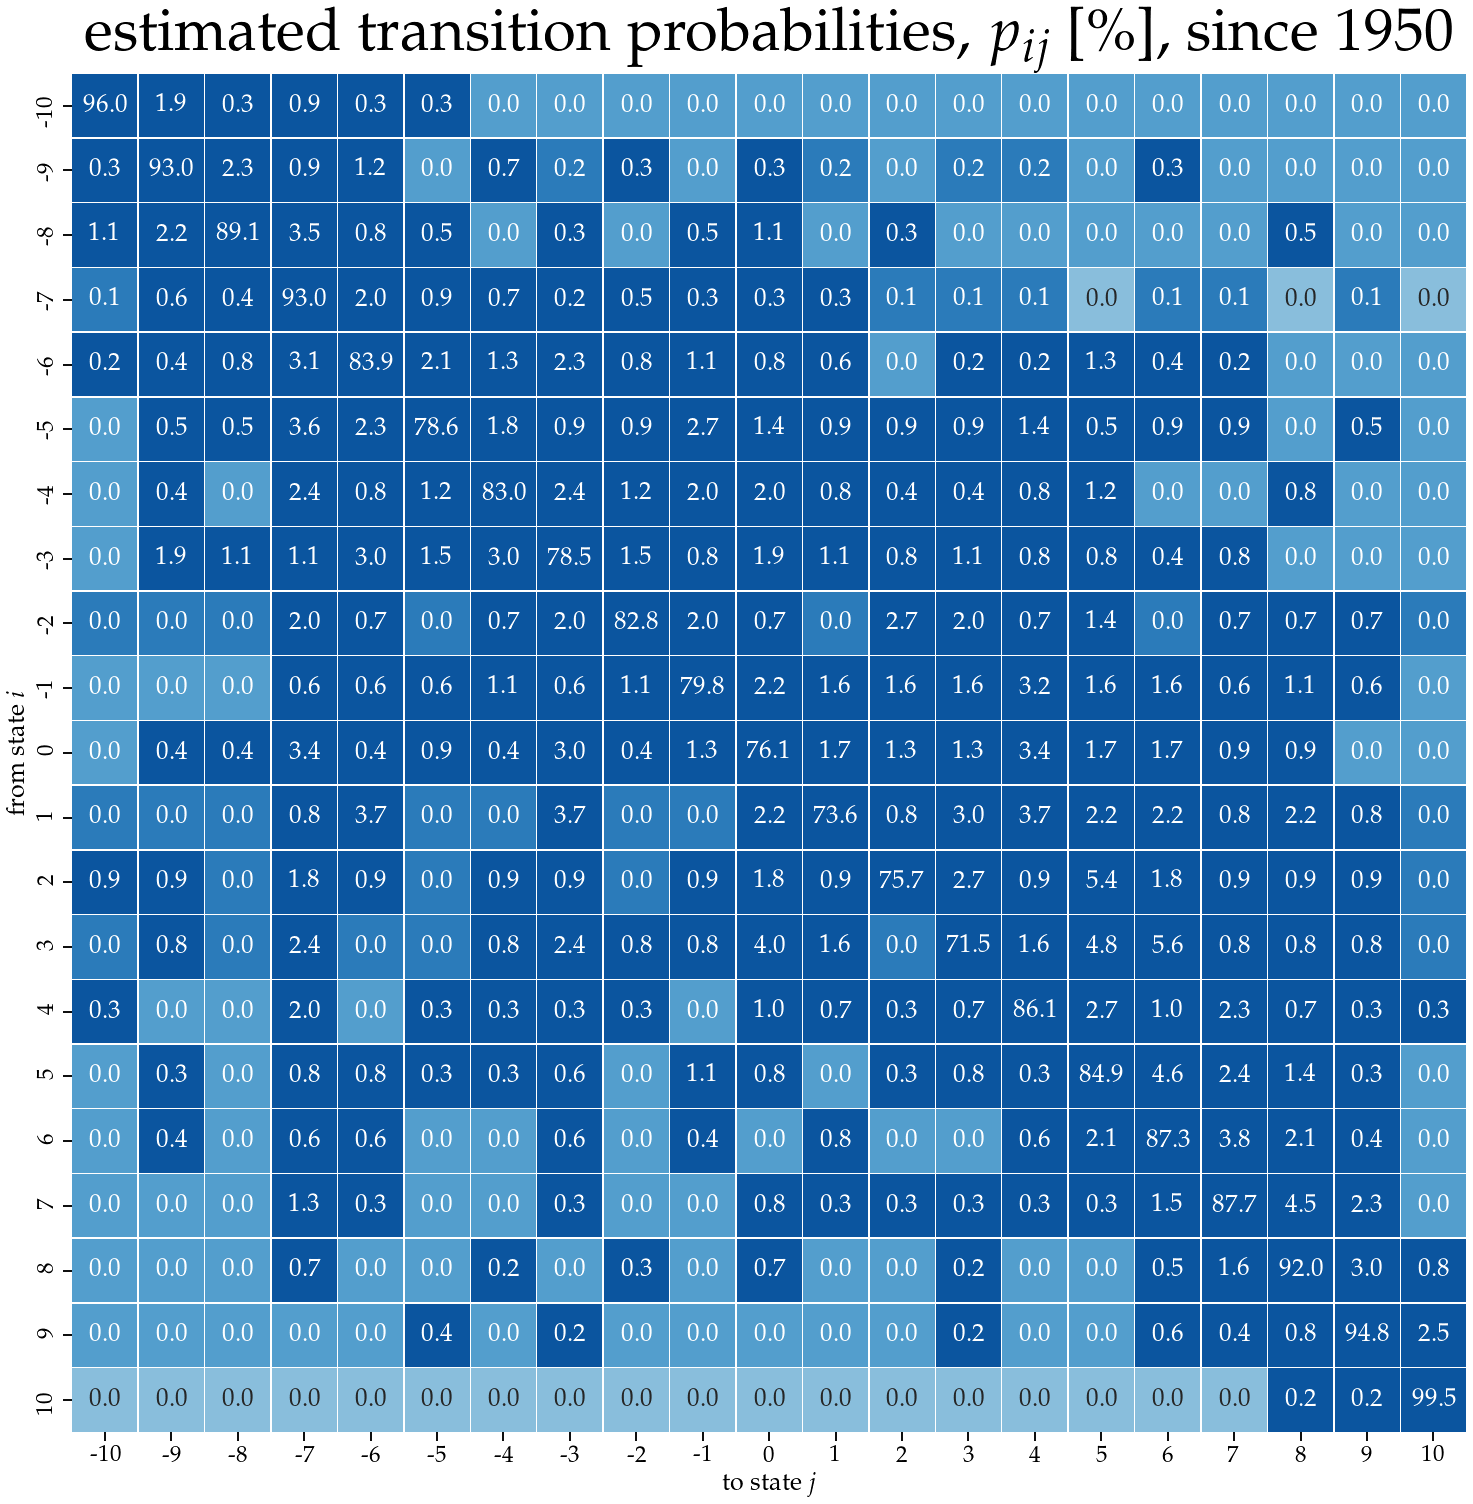

In [56]:
x_axis_labels = np.arange(-10,11,1)
y_axis_labels = np.arange(-10,11,1)
plt.figure(figsize=(25,25))
sns.heatmap(P_allCountries_Time1950*100, annot=True,fmt=".1f",cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels,norm=LogNorm(vmin=P_allCountries_Time1800.min(), vmax=P_allCountries_Time1800.max()), linewidths=.5,cmap=sns.color_palette("Blues"))
plt.ylabel(r'from state $i$')
plt.xlabel(r'to state $j$')
plt.title(r'estimated transition probabilities, $p_{ij}$ [$\%$], since 1950',size=60)
plt.savefig('./fig/estimatedTransitionProbabilities1950.pdf',bbox_inches='tight')